In [2]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import joblib


In [3]:
# Ensure code runs on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load test data
test_data_path = r"C:\Users\sanke\Desktop\Therapist_Model\Segmentation Data\Data\Final Data\Therapy_Session_Test.parquet"
test_df = pd.read_parquet(test_data_path)
print(f"Loaded test data with shape: {test_df.shape}")

Loaded test data with shape: (4529, 2)


In [5]:
# Load model, tokenizer and label encoder
saved_model_dir = r"C:\Users\sanke\Desktop\Therapist_Model\Saved Model"
tokenizer = RobertaTokenizer.from_pretrained(saved_model_dir)
model = RobertaForSequenceClassification.from_pretrained(saved_model_dir).to(device)
label_encoder = joblib.load(os.path.join(saved_model_dir, "label_encoder.pkl"))

In [6]:
# Encode labels
test_df["label"] = label_encoder.transform(test_df["speaker"])

# Tokenize test data
def tokenize_data(examples):
    return tokenizer(examples["utterance"], padding="max_length", truncation=True, max_length=512)

test_dataset = Dataset.from_pandas(test_df[['utterance']])
test_dataset = test_dataset.map(tokenize_data, batched=True)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

Map:   0%|          | 0/4529 [00:00<?, ? examples/s]

In [7]:
# DataLoader for batch inference
test_loader = DataLoader(test_dataset, batch_size=16)

In [8]:
# Perform inference
model.eval()
all_preds = []
all_labels = test_df["label"].tolist()

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, axis=-1).cpu().numpy()
        all_preds.extend(preds)

In [9]:
# Compute evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9033
F1 Score: 0.9032


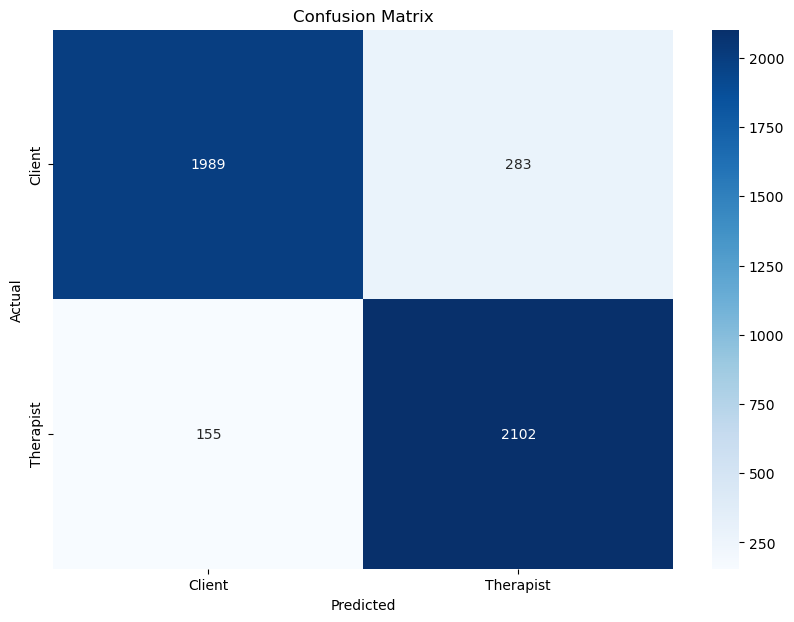

In [10]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
labels = label_encoder.classes_

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()